In [54]:
# default libs
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# geo dfs
import pandas as pd
import geopandas as gpd
import contextily as cx
# alterantive geoplots
import geoplot as gplt
import geoplot.crs as gcrs
import gps_filters
# audio libs
import soundfile as sf
import waveform_analysis
# OLS
from sklearn import linear_model

### Reading and Cleaning GPS data

In [44]:
# read in GPS data
df = pd.read_csv('..\\data\\TestDriveNoise_8May2024.csv')
# set datetime as datetime object
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y-%m-%d %H:%M:%S')
# remove idle time in garage
df = df.iloc[3_100:].reset_index()
# apply simple kallman filter to smooth movement and obtain better speeds later
lats, longs = gps_filters.simple_kallman(df['Latitude'], df['Longitude'])
df['Latitude'] = lats
df['Longitude'] = longs
# convert to geodataframe
gdf = gpd.GeoDataFrame(df[['DateTime', 'Longitude', 'Latitude']], 
                       geometry=gpd.points_from_xy(df.Longitude, df.Latitude), 
                       crs="EPSG:4326")
# calculate velocity
gdf = gdf.to_crs("EPSG:28992") # NL based projection for more accurate distance between points
velocities = [gdf['geometry'][max(0, i-2)].distance(gdf['geometry'][min(gdf.shape[0]-1, i+2)])/5*3.6
              for i in range(gdf.shape[0])]
gdf['speed'] = velocities
del velocities
# reset CRS for visualisation
gdf = gdf.to_crs("EPSG:4326")

### Visualizing vehicle speed during data collection

<GeoAxes: >

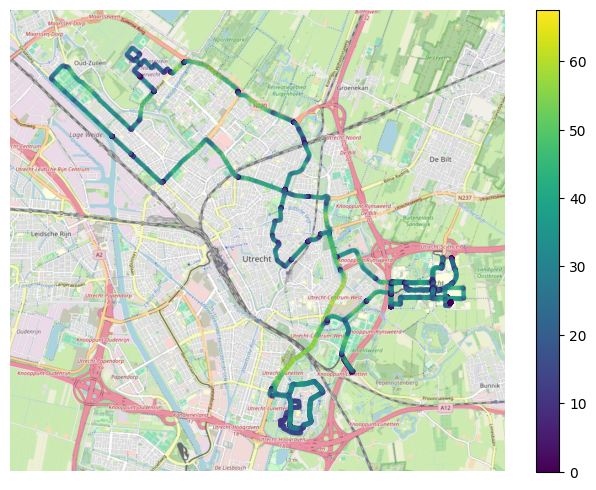

In [45]:
ax = gplt.webmap(gdf, projection=gcrs.WebMercator())
gplt.pointplot(gdf[:], hue='speed', marker='.', alpha=0.2, ax=ax, legend=True)

LEGEND <30: yellow, <20: orange, <10: red


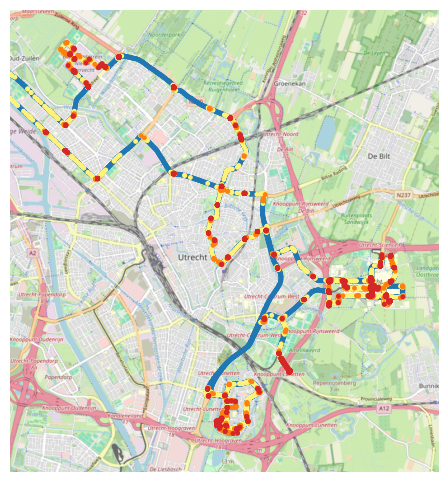

In [46]:
ax = gplt.webmap(gdf, projection=gcrs.WebMercator())
gplt.pointplot(gdf[:], marker='.', color='C0', ax=ax)
gplt.pointplot(gdf[gdf['speed'] < 30], marker='.', color='#fff27a', ax=ax)
gplt.pointplot(gdf[gdf['speed'] < 20], marker='.', color='C1', ax=ax)
gplt.pointplot(gdf[gdf['speed'] < 10], marker='.', color='C3', ax=ax)
print('LEGEND <30: yellow, <20: orange, <10: red')

### Reading in and cleaning normalizing sound data

In [47]:
soundfiles = [#'100300-recording1.wav', redacted due to inaccurate volume levels
              ('101445-recording2.wav', 113), 
              ('103545-recording3.wav', 113), 
              ('111100-recording4.wav', 145), 
              ('121648-recording5.wav', 145),
            #   ('achterafDbTest.wav', 145)
              ]
levelfile = '74DbA-tone.wav'

def signal_to_res(signal_frame, sr):
    weighted_signal = waveform_analysis.A_weight(signal_frame, sr)
    rms_value = np.sqrt(np.mean(np.abs(weighted_signal)**2))
    result = 20 * np.log10(rms_value)
    
    return result

def db_time_array(signal, sr, frame_duration=1, overlap=None):
    """
    args: 
    frame_size: in seconds
    """
    frame_size = int(frame_duration*sr)
    s_frame, e_frame = 0, frame_size+1
    result = []
    while e_frame < len(signal):
        result.append(signal_to_res(signal[s_frame:e_frame], sr))
        s_frame, e_frame = e_frame, e_frame+frame_size
    result.append(signal_to_res(signal[s_frame:], sr))
    return result

def file_to_db_list(filename, db_increment = 150):
    # 150 based on 74db tone file test
    # read in audio data
    data_folder = '..\\data\\may-collection-raw'
    file_path = os.path.join(data_folder, filename)
    signal, sr = sf.read(file_path)
    # convert to DbA values
    db_array = db_time_array(signal, sr, 1)
    db_array = [x + db_increment for x in db_array]
    return db_array

(10419,)
2024-05-08 8:14:45 511
2024-05-08 8:35:45 1771
2024-05-08 9:11:00 3886
2024-05-08 10:16:48 7834


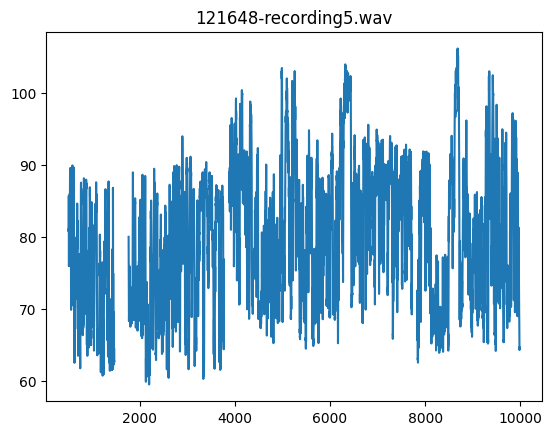

In [48]:
full_db_array = np.full(gdf.shape[0], np.NaN)
print(full_db_array.shape)
for file, adj in soundfiles:
    dba = file_to_db_list(file, adj)
    timestamp = f"2024-05-08 {int(file[:2])-2}:{file[2:4]}:{file[4:6]}"
    index = gdf[gdf['DateTime'] == timestamp].index.values[0]
    print(timestamp, index)

    full_db_array[index:index+len(dba)] = dba
    # print(timestamp)
    # print(file, dba[min(900, len(dba)-1)])
    # plt.plot(dba)
    # plt.title(file)
    # plt.show()

gdf['DbA'] = full_db_array
gdf_aud = gdf.dropna()

plt.plot(full_db_array)
plt.title(file)
plt.show()


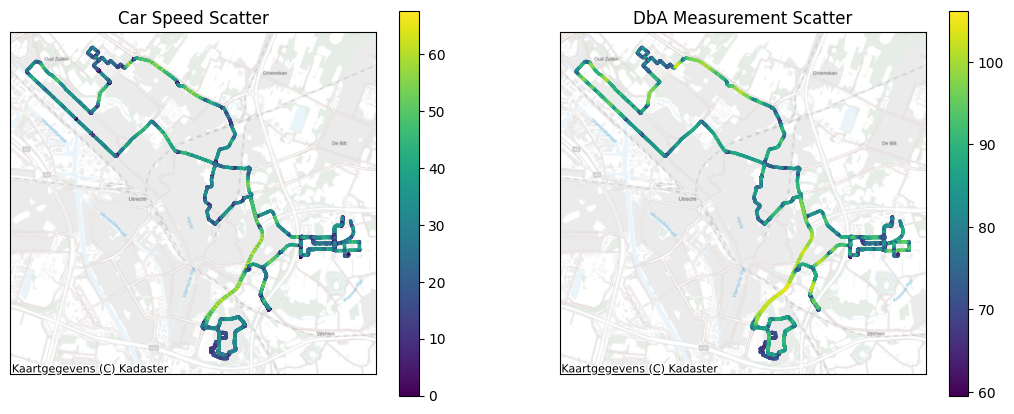

In [49]:
# gdf = gdf.to_crs("EPSG:4326")
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5))
gdf_aud = gdf_aud.to_crs("EPSG:28992")

gdf_aud.plot(column = 'speed', figsize=(6.5,5), legend=True, ax=ax1,
              markersize=2)
ax1.set_title('Car Speed Scatter')
gdf_aud.plot(column = 'DbA', figsize=(6.5,5), legend=True, ax=ax2,
             markersize=2)
ax2.set_title('DbA Measurement Scatter')

for ax in (ax1, ax2):
    ax.set_xticks([]); ax.set_yticks([])
    cx.add_basemap(ax, source=cx.providers.nlmaps.grijs, crs=gdf_aud.crs)

# gdf_aud[['geometry', 'speed', 'DbA']].explore(column='DbA')

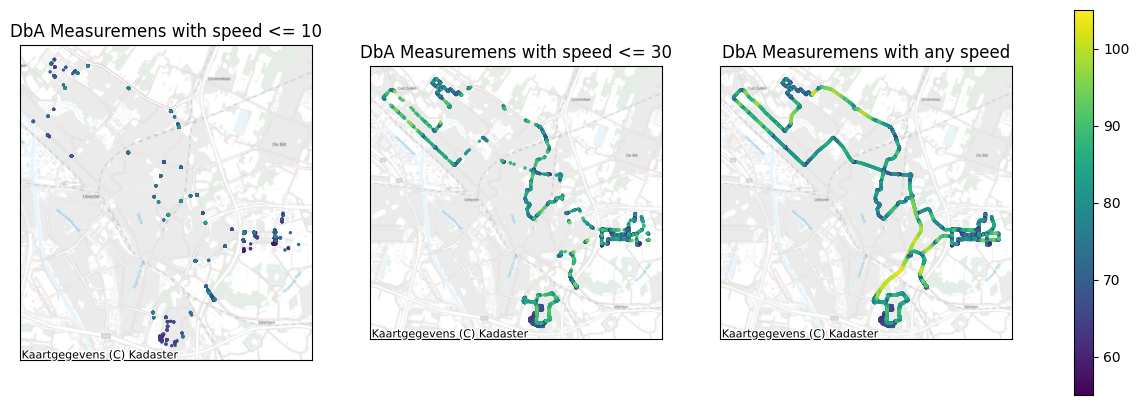

In [50]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,5))

cmap = mpl.colormaps['viridis']
norm = mpl.colors.Normalize(vmin=55, vmax=105)

gdf_aud[gdf_aud['speed'] <= 10].plot(column = 'DbA', ax=ax1,
              markersize=2)
ax1.set_title('DbA Measuremens with speed <= 10')

gdf_aud[gdf_aud['speed'] <= 30].plot(column = 'DbA', ax=ax2,
              markersize=2)
ax2.set_title('DbA Measuremens with speed <= 30')

gdf_aud[gdf_aud['speed'] < 100].plot(column = 'DbA', ax=ax3,
              markersize=2)
ax3.set_title('DbA Measuremens with any speed')


fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=(ax1,ax2,ax3))
for ax in (ax1, ax2, ax3):
    ax.set_xticks([]); ax.set_yticks([])
    cx.add_basemap(ax, source=cx.providers.nlmaps.grijs, crs=gdf_aud.crs)

# ax = gplt.webmap(gdf, projection=gcrs.WebMercator())
# gplt.pointplot(gdf_aud[gdf_aud['speed'] < 30], hue='DbA', marker='.', alpha=0.25, ax=ax, legend=True)

In [58]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

ols = smf.ols('DbA ~ speed', data=gdf_aud).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                    DbA   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                 1.901e+04
Date:                Tue, 21 May 2024   Prob (F-statistic):               0.00
Time:                        11:38:02   Log-Likelihood:                -27872.
No. Observations:                8953   AIC:                         5.575e+04
Df Residuals:                    8951   BIC:                         5.576e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     68.0856      0.102    666.478      0.0

OLS score: 0.6798551200609209
coef_: [[0.5303721]] intercept_: [68.08555534]


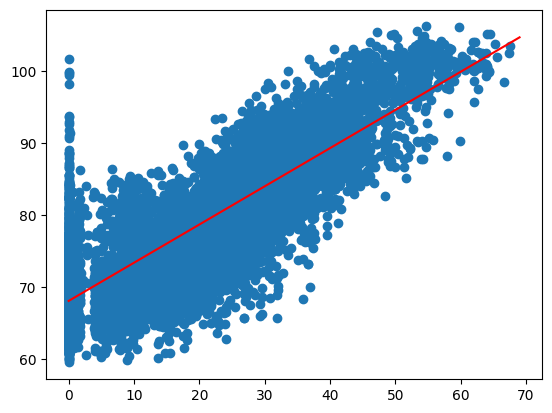

In [56]:
reg = linear_model.LinearRegression().fit(gdf_aud[['speed']], gdf_aud[['DbA']])
print(f"OLS score: {reg.score(gdf_aud[['speed']], gdf_aud[['DbA']])}")
print(f"coef_: {reg.coef_} intercept_: {reg.intercept_}")

reg_coef = reg.coef_[0][0]
gdf_aud['DbA_adjusted_ols'] = gdf['DbA'] - reg_coef * gdf['speed']

plt.scatter(gdf['speed'], gdf['DbA'])
plt.plot(range(0,70), [reg.intercept_[0] + reg.coef_[0][0] * x for x in range(0,70)], color='red')

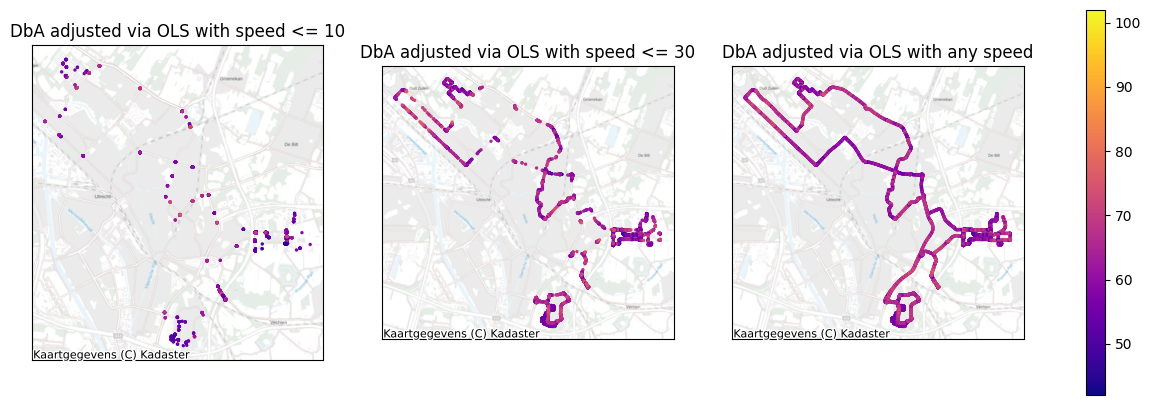

In [52]:
import matplotlib as mpl
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,5))

cmap = mpl.colormaps['plasma']
norm = mpl.colors.Normalize(vmin=42, vmax=102)

gdf_aud[gdf_aud['speed'] <= 10].plot(column = 'DbA_adjusted_ols', ax=ax1,
              markersize=2, cmap=cmap)
ax1.set_title('DbA adjusted via OLS with speed <= 10')

gdf_aud[gdf_aud['speed'] <= 30].plot(column = 'DbA_adjusted_ols', ax=ax2,
              markersize=2, cmap=cmap)
ax2.set_title('DbA adjusted via OLS with speed <= 30')

gdf_aud[gdf_aud['speed'] < 100].plot(column = 'DbA_adjusted_ols', ax=ax3,
              markersize=2, cmap=cmap)
ax3.set_title('DbA adjusted via OLS with any speed')


fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=(ax1,ax2,ax3))
for ax in (ax1, ax2, ax3):
    ax.set_xticks([]); ax.set_yticks([])
    cx.add_basemap(ax, source=cx.providers.nlmaps.grijs, crs=gdf_aud.crs)

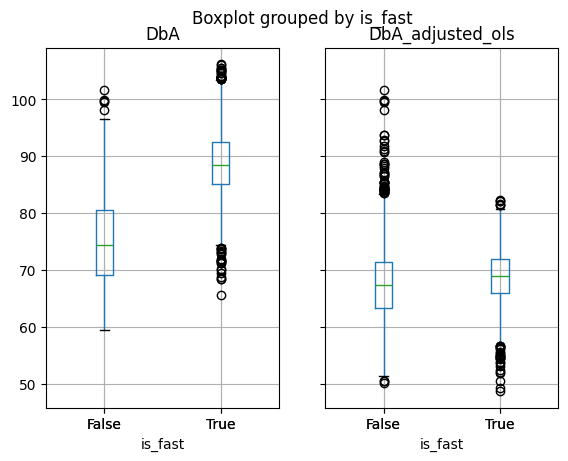

In [53]:
gdf_aud['is_fast'] = gdf_aud['speed'] > 30
fig = gdf_aud.boxplot(column=['DbA', 'DbA_adjusted_ols'], by='is_fast')